## Lyft Challenge!

https://www.udacity.com/lyft-challenge

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import pdb
from pathlib import Path

In [4]:
PATH = Path('data/lyft')
list(PATH.iterdir())

[PosixPath('data/lyft/train_masks'),
 PosixPath('data/lyft/train'),
 PosixPath('data/lyft/models'),
 PosixPath('data/lyft/tmp')]

In [5]:
def isolate_roads(filename):
    img = Image.open(filename)

    img_np = np.array(img)

    img_np_R = img_np[:,:,0] # Pull out R channel

    img_np_R[img_np_R == 7] = 255
    img_np_R[img_np_R == 6] = 255

    img_np_R[img_np_R != 255] = 0

    new_img = np.stack((img_np_R,img_np_R,img_np_R), axis=-1)
    
    image = Image.fromarray(new_img, 'RGB')
    dest = Path('data/lyft/train_masks')
    image.save(dest/filename.name)

In [6]:
VEHICLES = 10 # Data encoding in the segmented image
ROADS = 7
ROAD_LINES = 6

def show_img(im, figsize=(8,8), ax=None, alpha=None):
    if not ax: fix, ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

The following code takes the original labelled images and converts them to a more usable format. Run this code only once.

In [7]:
seg_PATH = Path('train/CameraSeg')
original_segs = list(seg_PATH.iterdir())

# for image in original_segs:
#     isolate_roads(image)

In [8]:
PATH = Path('data/lyft')
input_images = PATH/'train'
output_images = PATH/'train_masks'

list(input_images.iterdir())[:3]

[PosixPath('data/lyft/train/5.png'),
 PosixPath('data/lyft/train/88.png'),
 PosixPath('data/lyft/train/0.png')]

In [9]:
list(output_images.iterdir())[:3]

[PosixPath('data/lyft/train_masks/5.png'),
 PosixPath('data/lyft/train_masks/88.png'),
 PosixPath('data/lyft/train_masks/0.png')]

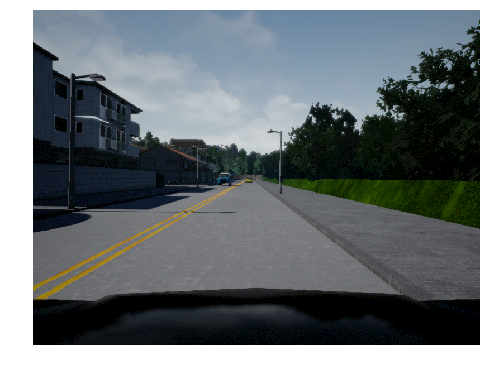

In [10]:
real_world = open_image(list(input_images.iterdir())[0])
show_img(real_world)

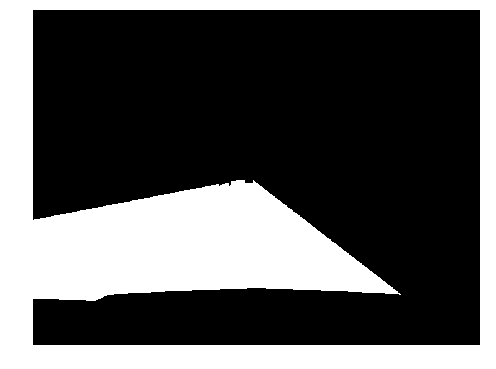

In [11]:
test_seg_image = open_image(list(output_images.iterdir())[0])
show_img(test_seg_image)

## Visualize data

In [12]:
TRAIN_DN = 'train'
MASKS_DN = 'train_masks'
sz = 128
bs = 64

In [13]:
ims = [open_image(list(input_images.iterdir())[i]) for i in range(16)]
masks = [open_image(list(output_images.iterdir())[i]) for i in range(16)]

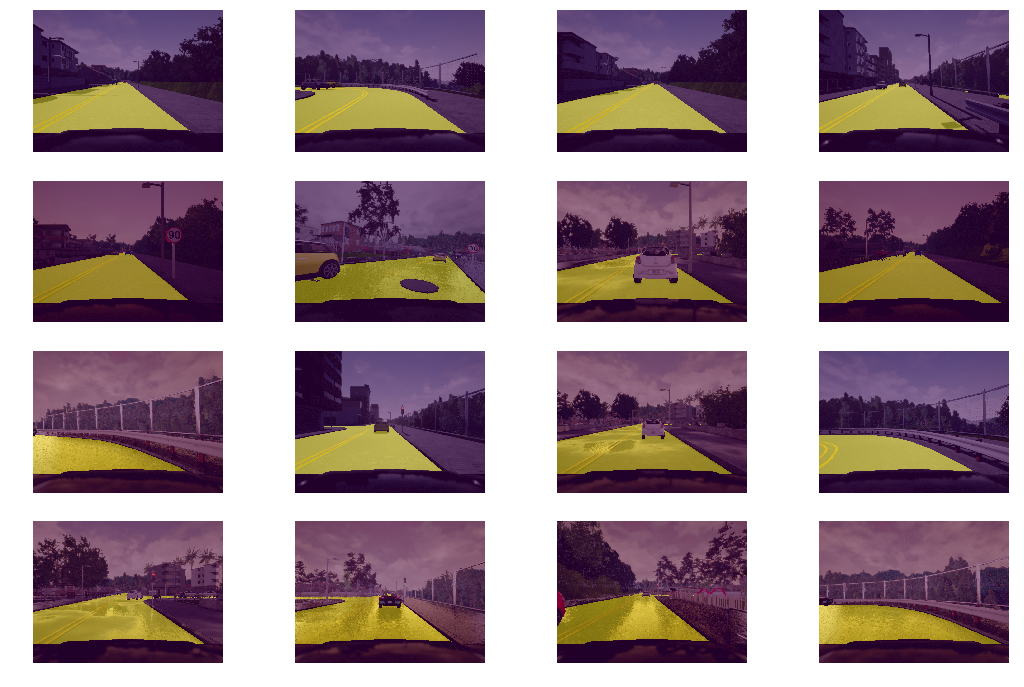

In [14]:
fig, axes = plt.subplots(4,4, figsize=(18,12))
for i, ax in enumerate(axes.flat):
    ax = show_img(ims[i], ax=ax)
    show_img(masks[i][...,0], ax=ax, alpha=0.5)

In [15]:
class MatchedFilesDatset(FilesDataset):
    def __init__(self, filenames, y, transform, path):
        assert(len(filenames == len(y)))
        self.y = y
        super().__init__(filenames, transform, path)
        
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    
    def get_c(self): return 0

In [16]:
x_names = np.array(list((PATH/TRAIN_DN).iterdir()))
y_names = np.array(list((PATH/MASKS_DN).iterdir()))

len(x_names), len(y_names)

(1000, 1000)

In [17]:
val_idxs = list(range(len(x_names)//5)) # 20% validation split
((val_x, trn_x),(val_y, trn_y)) = split_by_idx(val_idxs, x_names, y_names) # split the in/out pairs the same

In [18]:
len(val_x),len(trn_x),trn_x[0], trn_y[0]

(200,
 800,
 PosixPath('data/lyft/train/284.png'),
 PosixPath('data/lyft/train_masks/284.png'))

In [19]:
aug_tfms = [RandomRotate(4, tfm_y=TfmType.CLASS),
            RandomFlip(tfm_y=TfmType.CLASS),
            RandomLighting(0.05, 0.05)]

In [20]:
transforms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDatset, (trn_x,trn_y), (val_x,val_y), transforms, path='')
md = ImageData(PATH, datasets, bs, num_workers=8, classes=None)

In [21]:
denorm = md.trn_ds.denorm
x,y = next(iter(md.aug_dl))
x = denorm(x)

In [23]:
# This cell is for educational purposes, to see inside the resnet arch

# class Empty(nn.Module): 
#     def forward(self,x): return x

# models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=Empty())
# learn = ConvLearner(md, models)
# learn.summary()

In [22]:
class StdUpsample(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.conv = nn.ConvTranspose2d(nin, nout, 2, stride=2)
        self.bn = nn.BatchNorm2d(nout)
        
    def forward(self, x): return self.bn(F.relu(self.conv(x)))

In [26]:
def not_lambda(x): return x[:,0] # TODO: Rename this please

flatten_channel = Lambda(not_lambda)

In [27]:
simple_up = nn.Sequential(
    nn.ReLU(),
    StdUpsample(512,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    nn.ConvTranspose2d(256, 1, 2, stride=2),
    flatten_channel
)

In [28]:
models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=simple_up)
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5)]

 92%|█████████▏| 12/13 [00:06<00:00,  1.90it/s, loss=5.07] 


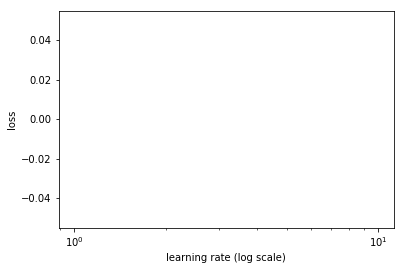

In [56]:
learn.lr_find()
learn.sched.plot()

In [57]:
lr=4e-2

In [58]:
learn.fit(lr,1,cycle_len=5,use_clr=(20,5))

epoch      trn_loss   val_loss   <lambda>                  
    0      0.406238   6.083686   0.673004  
    1      0.264354   0.374917   0.892876                  
    2      0.20566    0.150802   0.943083                  
    3      0.17279    0.106236   0.952836                  
    4      0.151531   0.103665   0.954153                  



[array([0.10367]), 0.9541534423828125]

In [59]:
learn.save('tmp')

In [60]:
torch.save(learn.model, 'road-fullmodel.pt')

/home/officialdanielhunter/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type StdUpsample. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [32]:
learn.load('tmp')

In [33]:
py,ay = learn.predict_with_targs()

In [34]:
ay.shape

(200, 128, 128)

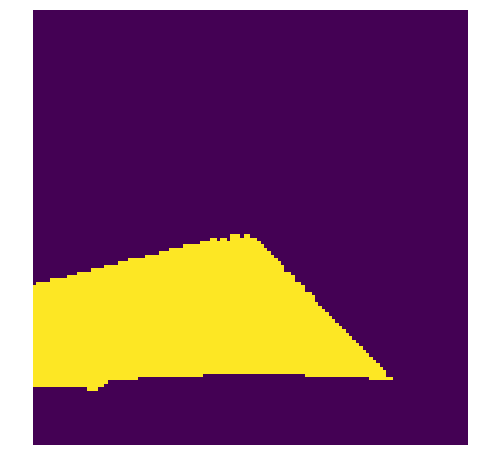

In [35]:
show_img(ay[0]);

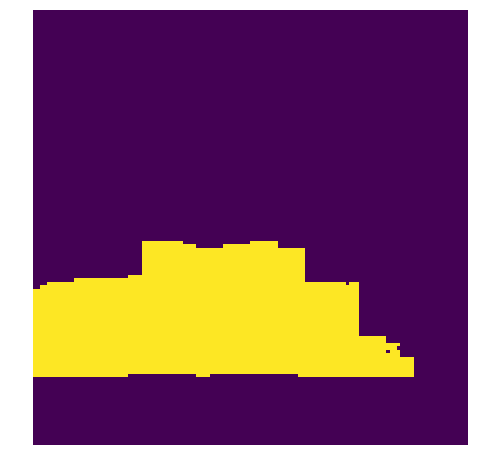

In [36]:
show_img(py[0]>0);

In [37]:
learn.unfreeze()

In [38]:
learn.bn_freeze(True)

In [39]:
lrs = np.array([lr/100, lr/10, lr])/4

In [40]:
learn.fit(lrs, 1, cycle_len=20, use_clr=(20,10))

epoch      trn_loss   val_loss   <lambda>                  
    0      0.280583   0.162034   0.907189  
    1      0.215582   0.134043   0.929378                  
    2      0.17163    0.08487    0.962581                  
    3      0.141084   0.076518   0.967511                  
    4      0.120566   0.064099   0.972872                  
    5      0.105807   0.060142   0.975824                  
    6      0.094496   0.053192   0.977518                   
    7      0.085472   0.049443   0.979436                   
    8      0.077409   0.046487   0.982145                   
    9      0.071044   0.044638   0.982182                   
    10     0.065365   0.042435   0.982854                   
    11     0.060627   0.038757   0.984857                   
    12     0.056245   0.036656   0.985684                   
    13     0.052472   0.035464   0.986367                   
    14     0.049233   0.034285   0.986442                   
    15     0.046292   0.032907   0.987472      

[array([0.02886]), 0.9891598510742188]

In [41]:
py,ay = learn.predict_with_targs()

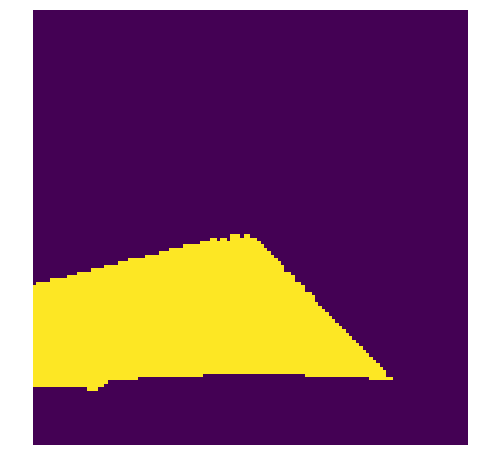

In [42]:
show_img(ay[0]);

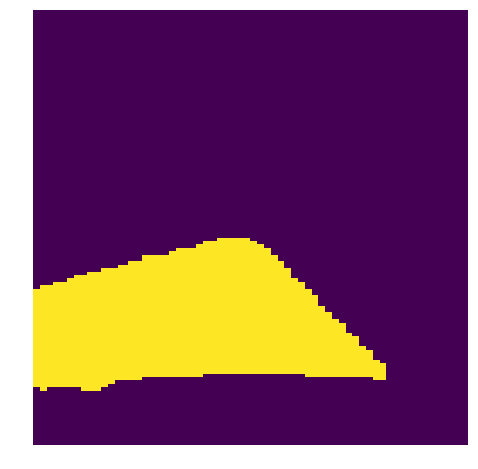

In [43]:
show_img(py[0]>0);

In [44]:
learn.save('road-128')

In [102]:
torch.save(learn.model, 'road-fullmodel.pt')
# torch.save(learn.model.state_dict(), 'road-weights.pt')

/home/officialdanielhunter/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type StdUpsample. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [103]:
sz = 512
bs = 16

In [104]:
transforms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDatset, (trn_x,trn_y), (val_x,val_y), transforms, path='')
md = ImageData(PATH, datasets, bs, num_workers=8, classes=None)

In [105]:
models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=simple_up)
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5)]

In [106]:
learn.load('road-128')

 94%|█████████▍| 47/50 [01:03<00:04,  1.36s/it, loss=11.1] 

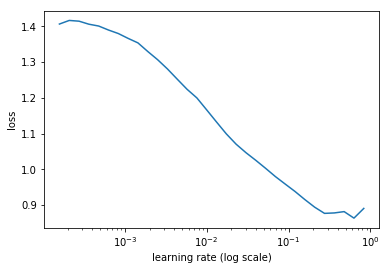

In [107]:
learn.lr_find()
learn.sched.plot()

In [108]:
lr=4e-2
learn.fit(lr,1,cycle_len=5,use_clr=(20,5))

  0%|          | 0/50 [00:00<?, ?it/s]
epoch      trn_loss   val_loss   <lambda>                  
    0      0.290031   0.156104   0.928065  
    1      0.136327   0.065751   0.975856                  
    2      0.0847     0.050194   0.980458                   
    3      0.064376   0.043003   0.982409                   
    4      0.054101   0.040057   0.983521                   



[array([0.04006]), 0.9835213279724121]

In [109]:
learn.save('512')

In [118]:
itr = iter(md.val_dl)
x,y = next(iter(itr))
x1,y1 = next(iter(itr))
py = to_np(learn.model(V(x1)))

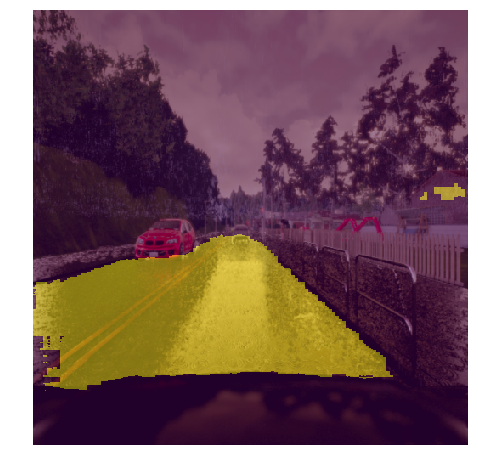

In [119]:
ax = show_img(denorm(x1)[0])
show_img(py[0]>0, ax=ax, alpha=0.5)

In [114]:
denorm(x).shape

(16, 512, 512, 3)

In [120]:
md.val_dl.